In [1]:
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *

After setup phase, we now download data

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

path has 2 folders which are `images`and `annotations`. But we only need `images`

In [4]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('images'),Path('annotations')]

Creating data holder template and calling dataloaders

In [5]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dls = pets.dataloaders(path/'images')

Let's see some images in dataset

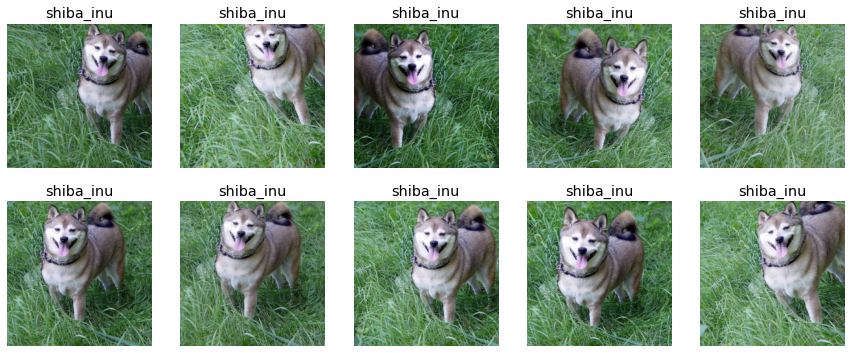

In [7]:
dls.show_batch(max_n=10, nrows=2, unique=True)

Train our very first model 

In [8]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.542966,0.350839,0.104195,01:31


epoch,train_loss,valid_loss,error_rate,time
0,0.469088,0.322516,0.100812,01:57
1,0.366829,0.251349,0.077808,02:03
2,0.222574,0.213463,0.064276,01:57


Using our model to check our dataset 

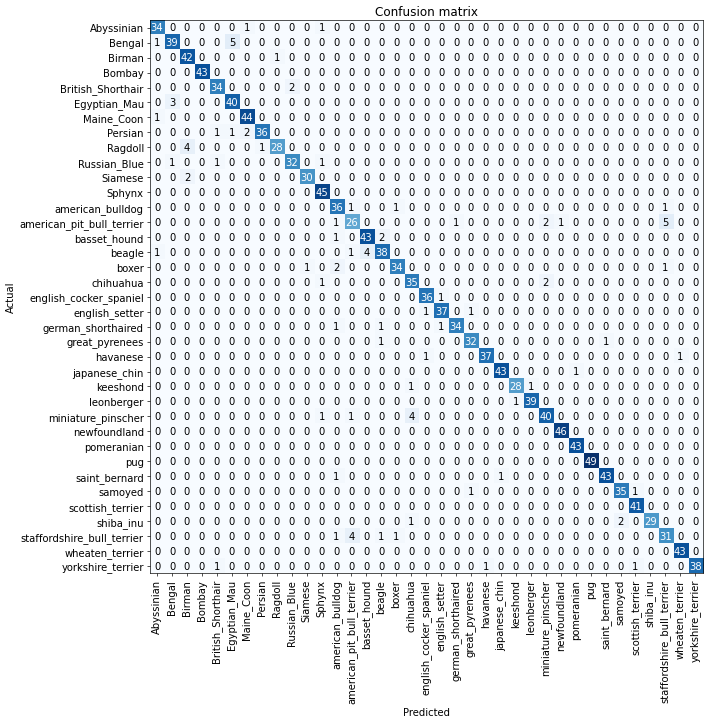

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

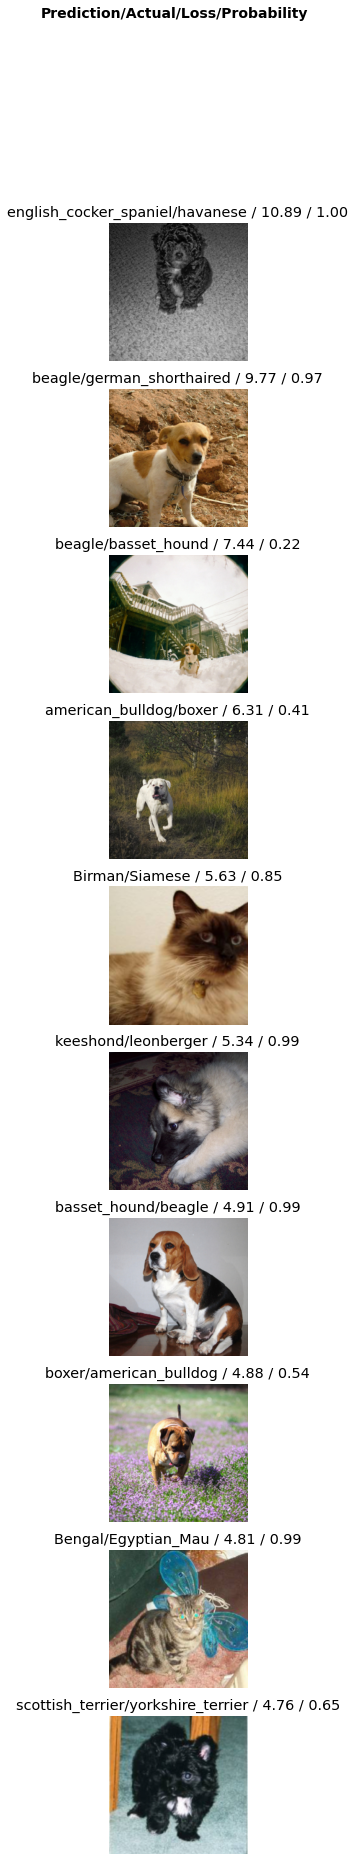

In [10]:
interp.plot_top_losses(10, nrows=10, ncols=1)

both most confused results, that we got, are so similar to each other. So, that is acceptable

In [11]:
interp.most_confused(min_val=5)

[('Bengal', 'Egyptian_Mau', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5)]

In order to improve our model, lets find the more efficient `learning rate`

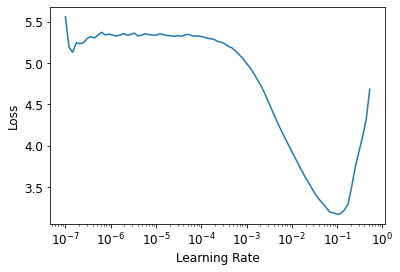

In [6]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

We got the *minimum loss* point and the *steepest* point

In [7]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 3.02e-03


let's change the `learning rate` and train the model again

In [15]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.286615,0.357596,0.111637,01:32


epoch,train_loss,valid_loss,error_rate,time
0,0.531504,0.493996,0.146820,01:59
1,0.376871,0.284685,0.082544,01:59
2,0.218652,0.251856,0.077131,01:59


It doesn't get much better, so we need to use other approach

In [8]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.051423,0.485274,0.144114,01:31
1,0.584739,0.313523,0.098106,01:30
2,0.349831,0.255951,0.081867,01:30


Now we unfreeze our model and find a new `learning rate`

In [9]:
learn.unfreeze()

SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=9.12010818865383e-07)

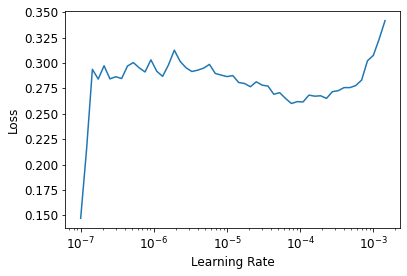

In [10]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(6, lr_max=5e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.251060,0.226179,0.072395,01:58
1,0.242465,0.222136,0.065629,01:58
2,0.232455,0.219788,0.064953,01:58
3,0.229549,0.215825,0.064953,01:57
4,0.227390,0.215592,0.065629,01:57
5,0.202224,0.213805,0.065629,01:58


Because each layers require different `learning rate` so we gonna change the lr as we train each layers  
let's wrap it up in one step

In [12]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 5e-3)
learn.unfreeze()
learn.fit_one_cycle(14, lr_max=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,1.054992,0.485799,0.135995,01:30
1,0.570196,0.332198,0.104195,01:31
2,0.355217,0.245689,0.077808,01:30


epoch,train_loss,valid_loss,error_rate,time
0,0.262778,0.242210,0.077808,01:57
1,0.253626,0.237780,0.076455,01:57
2,0.246198,0.235773,0.075101,01:57
3,0.244757,0.232648,0.071719,01:57
4,0.226256,0.225939,0.073072,01:57
5,0.227157,0.226794,0.070365,01:57
6,0.203874,0.223198,0.068336,01:57
7,0.209573,0.225940,0.065629,01:57
8,0.198896,0.218464,0.067659,01:57
9,0.196812,0.217922,0.068336,01:57


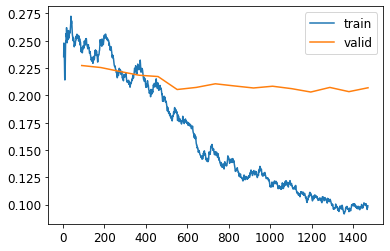

In [7]:
learn.recorder.plot_loss()

In [8]:
learn.export()

In [9]:
modelPath = Path()
modelPath.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]